In [1]:
import os
from datetime import datetime
import spacy
from datasets import load_metric
from tqdm import tqdm
from transformers import AutoTokenizer
import re
import numpy as np
from typing import List, Tuple, Dict, Optional, Union
from string import punctuation
from pathlib import Path
import pandas as pd
import sys
from statistics import mean
from collections import Counter
from transformers.data.metrics.squad_metrics import normalize_answer

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns; sns.set_theme(color_codes=True)


In [2]:
base_model = "det5-base"
data = "v-splits_220512"

tokenizer = AutoTokenizer.from_pretrained(f'../results/{base_model}/{data}/lead_generation')
rouge = load_metric("rouge")

single_task_exp_dirs = [
    Path(f'../results/{base_model}/{data}/title_generation'),
    Path(f'../results/{base_model}/{data}/lead_generation'),
    Path(f'../results/{base_model}/{data}/summary_generation'),
    Path(f'../results/{base_model}/{data}/caption_generation'),
    Path(f'../results/{base_model}/{data}/category_prediction'),
    Path(f'../results/{base_model}/{data}/reading_time_prediction'),
]

# multi_task_exp_dir = Path(f'../results/{base_model}/{data}/multitask')
multi_task_exp_dir = Path(f'../results/{base_model}/{data}/multitask_cont')

In [3]:
def load_data(test_set: str) -> pd.DataFrame:
    df = pd.read_json(test_set, lines=True)
    return df

def load_generations(pred_file: str) -> List[str]:
    with open(pred_file, 'r', encoding='utf8') as f:
        preds = [line.strip() for line in f]
    return preds

def stringify(lst: List) -> str:
    """
    convert a list of strings into a single string of tokens that can be safely seperated by whitespace (for `compute_f1` in `squad_metrics`)
    """
    lst = [re.sub('\s+', '_', item) for item in lst]
    return ' '.join(lst)

def concatenate_list(l: List[str], delimiter: str = '•') -> str:
    """
    join a list of bullet point summaries into a single string
    """
    return f'{delimiter} ' + f' {delimiter} '.join(map(str.strip, l))

def is_substring(str_a: str, str_b: str) -> bool:
    return str_a in str_b

def dedupe_list(l: List[str]) -> List[str]:
    deduped = []
    for i in range(len(l)):
        if l[i] and l[i] not in deduped:
            add = True
            for s in deduped:
                if is_substring(l[i], s):
                    add = False
            if add:
                deduped.append(l[i])
    return deduped

def detokenize(lst: List[int], tokenizer=tokenizer):
    return tokenizer.decode(lst, skip_special_tokens=True, clean_up_tokenization_spaces=True)

def inspect_exact_match_errors(df: pd.DataFrame, reference_column: str) -> pd.DataFrame:
    error_df = df[df[reference_column] != df['predictions']]
    print(f'total errors: {len(error_df)}, proportion {(len(error_df)/len(df))*100:.3f}%')
    return error_df

def split_prefix_text(text: str) -> Tuple[str]:
    prefix, text = text.split(':', 1)
    return prefix +': ', text.strip()


def compute_f1(pred: List[str], ref: List[str]) -> Tuple[float]:
    """
    adapted from https://github.com/huggingface/transformers/blob/main/src/transformers/data/metrics/squad_metrics.py 
    to return precision, recall and f1
    """
    pred = [normalize_answer(p) for p in pred]
    ref = [normalize_answer(r) for r in ref]
    common = Counter(pred) & Counter(ref)
    num_same = sum(common.values())
    
    if len(pred) == 0 or len(ref) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(pred == ref), int(pred == ref), int(pred == ref)
    if num_same == 0:
        return 0, 0, 0
    
    precision = 1.0 * num_same / len(pred)
    recall = 1.0 * num_same / len(ref)
    f1 = (2 * precision * recall) / (precision + recall)
    
    return precision, recall, f1

def mean_p_r_f1(predictions: List[List[str]], references: List[List[str]]) -> Tuple[float]:
    """
    given a list of prediction strings and reference strings, 
    calls `compute_f1` from `squad_metrics` on on each and returns the mean
    """
    scores = [compute_f1(pred, ref) for pred, ref in zip(predictions, references)]
#     print(scores[:10])
    p = np.array([score[0] for score in scores]).mean()
    r = np.array([score[1] for score in scores]).mean()
    f1 = np.array([score[2] for score in scores]).mean()
    
    return p, r, f1

def exact(predictions: Union[List, str], references: Union[List, str]) -> Tuple:
    """
    computes exact matches between strings or lists of strings
    this implementation differs from that defined in `squad_metrics`
    """
    assert len(predictions) == len(references), "length of predictions and references does not match"
    assert type(predictions[0]) == type(references[0]), "type of reference values does not match type of predictions"
#     import pdb;pdb.set_trace()
    scores = []
    total_refs = []
    
    if isinstance(predictions[0], list): # compute for list of items (potentially different lengths)
        for prediction, reference in zip(predictions, references):
            unique_preds = set((normalize_answer(x) for x in prediction if x))
            unique_refs = set((normalize_answer(x) for x in reference if x))
            exact_match = unique_refs.intersection(unique_preds)
            scores.append(len(exact_match))
            total_refs.append(len(unique_refs))
            # print('pred:', prediction, 'ref:', reference, 'score:', scores[-1]) # sanity check

    else: # expects exact string match between prediction and reference
        for p, r in zip(predictions, references):
            if normalize_answer(p) == normalize_answer(r):
                scores.append(1)
            else:
                scores.append(0)
        
    scores = np.array(scores) # .mean()
    total_refs = np.array(total_refs)
    
#     import pdb; pdb.set_trace()
    perc_match = scores.sum() / total_refs.sum()
    
    return scores, scores.mean(), perc_match

def score_pred_generations(predictions: List[str], references: List[str]) -> Dict:
    # note, we deduplicate lists before computing rouge, to avoid punsihing repititions that are easily removed
    if isinstance(references[0], list):
        references = [concatenate_list(ref) for ref in references]
    predictions = [concatenate_list(dedupe_list(re.split('\s?•\s?', p))) for p in predictions]
    assert type(references[0]) == type(predictions[0]), "type of reference values does not match type of predictions"
    
    results = rouge.compute(predictions=predictions, references=references, use_stemmer=True)
    
    return {k: results[k].mid.fmeasure for k in results.keys()}
    
def score_pred_labels(predictions: List[str], references: List[str]) -> Dict:
    
    # convert strings values like "• Israel • USA • USA • Donald Trump" to list ["Israel","USA", "USA", "Donald Trump"]
    if not isinstance(references[0], list):
        references = [re.split('\s?•\s?', r) for r in references]
    if not isinstance(predictions[0], list):
        predictions = [re.split('\s?•\s?', p) for p in predictions]
    
    print(predictions[:10])
    print(references[:10])
#     import pdb;pdb.set_trace()
    predictions = [dedupe_list(p) for p in predictions]  
#     print(predictions[:10])
    assert type(references[0]) == type(predictions[0]), "type of reference values does not match type of predictions"
    
    p, r, f1 = mean_p_r_f1(predictions, references)
    
    exact_matches_total, exact_matches_mean, exact_matches_prec = exact(predictions, references)
    
    return {
        'exact match total': exact_matches_total,
        'exact match avg': exact_matches_mean,
        'exact match %': exact_matches_prec,
        'precision': p,
        'recall': r,
        'f1': f1,
    }
    
def score_predictions(df) -> Dict:
    task_scores = {}

    for task_prefix in df['task_prefix'].unique():
        sub_df = df[df['task_prefix'] == task_prefix]
        print(f'Subset DF for task `{task_prefix}` has length: {len(sub_df)}')

        if task_prefix.strip() == 'predict reading time:':
            references = list(map(str, sub_df['readingTime'].to_list())) if 'readingTime' in sub_df.columns else sub_df['reference'].to_list()
            predictions = sub_df['prediction'].to_list()
            task_scores['reading time prediction'] = score_pred_labels(predictions, references)
            if len(df['task_prefix'].unique()) > 1:
                compare_prediction_distribution(predictions, references, '../plots/reading_time_preds_multitask.png')
            else:
                compare_prediction_distribution(predictions, references, '../plots/reading_time_preds_singletask.png')
                
        elif task_prefix.strip() == 'categorize:':
            references = sub_df['category'].to_list() if 'category' in sub_df.columns else sub_df['reference'].to_list()
            predictions = sub_df['prediction'].to_list()
            task_scores['category prediction'] = score_pred_labels(predictions, references)
            
        elif task_prefix.strip() == 'generate title:':
            references = sub_df['title'].to_list() if 'title' in sub_df.columns else sub_df['reference'].to_list()
            predictions = sub_df['prediction'].to_list()
            assert type(references[0]) == type(predictions[0]), "type of reference values does not match type of predictions"
            task_scores['title generation'] = score_pred_generations(predictions, references)

        elif task_prefix.strip() == 'generate lead:':
            references = sub_df['lead'].to_list() if 'lead' in sub_df.columns else sub_df['reference'].to_list()
            predictions = sub_df['prediction'].to_list()
            assert type(references[0]) == type(predictions[0]), "type of reference values does not match type of predictions"
            task_scores['lead generation'] = score_pred_generations(predictions, references)

        elif task_prefix.strip() == 'summarize:':
            references = sub_df['summary'].to_list() if 'summary' in sub_df.columns else sub_df['reference'].to_list()
            predictions = sub_df['prediction'].to_list()
            task_scores['summary generation'] = score_pred_generations(predictions, references)

        elif task_prefix.strip() == 'caption:':
            references = sub_df['pictureText'].to_list() if 'pictureText' in sub_df.columns else sub_df['reference'].to_list()
            predictions = sub_df['prediction'].to_list()
            task_scores['caption generation'] = score_pred_generations(predictions, references)

        else:
            raise RunTimeError(f"Could not find task for prefix {task_prefix.strip()}")
            
    return task_scores

def get_dataframe(exp_dir):
    test_set = exp_dir / 'predict_dataset.json'
    pred_file = exp_dir / 'generated_predictions.txt'

    print(f'test set last modified: {datetime.fromtimestamp(os.stat(test_set).st_mtime)}')
    print(f'predictions file last modified: {datetime.fromtimestamp(os.stat(test_set).st_mtime)}')
    
    df = load_data(test_set)

    print(f'Dataset length: {len(df)}')
    
    df['prediction'] = load_generations(pred_file)
    print(df.columns)
    # in some cases, the predict dataset was saved after tokenization, so this needs to be reversed...
#     import pdb;pdb.set_trace()
    if 'readingTime' in df.columns:
        # values recieve type float due to NaNs for additional tasks in MT setting.
        # fill NaNs with 0 to convert them to integer strings
        df['readingTime']= df['readingTime'].fillna(0).astype(int).astype(str)
    if 'attention_mask' in df.columns:
    #     print(type(df['input_ids'][0]))
        df['input'] = df['input_ids'].apply(detokenize)
        df['reference'] = df['labels'].apply(detokenize)
        df.drop(columns=['input_ids', 'attention_mask', 'labels'], inplace=True)
    if not 'task_prefix' in df.columns:
        df['task_prefix'], df['input'] = zip(*df['input'].apply(split_prefix_text))
    
    return df

def compare_prediction_distribution(predictions: Union[List, str], references: Union[List, str], save_as: str = None):
    """
    makes plot to compare the distribution of a model's predicted reading times vs. the true reading times
    """
    if isinstance(references[0], list):
        references = np.array([int(float(r[0])) for r in references])
    else:
        references = np.array([int(float(r)) for r in references])
        
    if isinstance(predictions[0], list):
        predictions = np.array([int(float(p[0])) for p in predictions])
    else:
        predictions = np.array([int(float(p)) for p in predictions])
    
    df = pd.DataFrame({'predicted': predictions, 'true': references})
    df = df.melt()
    
    ticks = np.arange(df['value'].min(), df['value'].max()+1, step=60)
    
    fs = 14

#     g = sns.displot(df, x="value", hue="variable", discrete=True, shrink=20, multiple='dodge')        
    g = sns.catplot(x="value", hue="variable", kind="count",
            palette="pastel", edgecolor=".6",
            data=df, 
            height=4, # make the plot 5 units high
            aspect=1, # height should be n times width
            legend=False,
            legend_out=False,
                    
            )
    
    # set all fonts in facetgrid
    g.axes[0,0].set_xlabel('Reading Times', fontsize=fs)
    g.axes[0,0].set_ylabel('Counts', fontsize=fs)
    g.axes[0,0].legend(fontsize=fs, loc='upper right')
    g.axes[0,0].tick_params(axis='both', which='major', labelsize=fs*0.8)
#     g.axes[0,0].set_title('Distibution of Estimated Reading Times', fontsize=fs*1.2)
    g.axes[0,0].set_yscale("log")
    
    if save_as is not None:
        print(f'saving fig to {save_as}...')
        g.savefig(save_as, dpi=300, tight_layout=True)
        
    return


In [4]:
# refs = [["the cat", "theater", "YELLING a lot", "agent007", 'another'], ['barack', 'US']]
# preds = [["the cat?", "theater", "yelling", "agent"], ['Barack', 'US']]

refs = [["120", "160"], ["60"], ["180"], ['60'], ['180.0']]
preds = [["160"], ["180"], ['60'], ['60'], ['120.0']]
print(score_pred_labels(preds, refs))
# compare_prediction_distribution(preds, refs, '../plots/dummy1.png')
refs = ["120", "60", "180", '60', '180']
preds = ["120", "180", '60', '60', '120.0']
print(score_pred_labels(preds, refs))
# compare_prediction_distribution(preds, refs, '../plots/dummy2.png')


[['160'], ['180'], ['60'], ['60'], ['120.0']]
[['120', '160'], ['60'], ['180'], ['60'], ['180.0']]
{'exact match total': array([1, 0, 0, 1, 0]), 'exact match avg': 0.4, 'exact match %': 0.3333333333333333, 'precision': 0.4, 'recall': 0.3, 'f1': 0.3333333333333333}
[['120'], ['180'], ['60'], ['60'], ['120.0']]
[['120'], ['60'], ['180'], ['60'], ['180']]
{'exact match total': array([1, 0, 0, 1, 0]), 'exact match avg': 0.4, 'exact match %': 0.4, 'precision': 0.4, 'recall': 0.4, 'f1': 0.4}


**********
../results/det5-base/v-splits_220512/title_generation
test set last modified: 2022-05-13 22:33:02.756328
predictions file last modified: 2022-05-13 22:33:02.756328
Dataset length: 4505
Index(['id', 'title', 'titleHeader', 'content', 'task_prefix', 'prediction'], dtype='object')
Subset DF for task `generate title: ` has length: 4505
**********
../results/det5-base/v-splits_220512/lead_generation
test set last modified: 2022-05-14 00:51:58.815929
predictions file last modified: 2022-05-14 00:51:58.815929
Dataset length: 4508
Index(['id', 'lead', 'content', 'task_prefix', 'prediction'], dtype='object')
Subset DF for task `generate lead: ` has length: 4508
**********
../results/det5-base/v-splits_220512/summary_generation
test set last modified: 2022-05-14 00:51:54.511865
predictions file last modified: 2022-05-14 00:51:54.511865
Dataset length: 2696
Index(['id', 'summary', 'content', 'task_prefix', 'prediction'], dtype='object')
Subset DF for task `summarize: ` has length: 2696

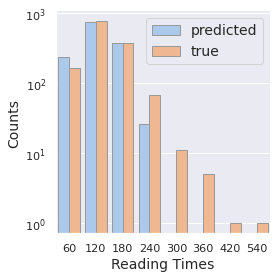

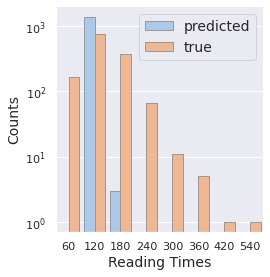

In [5]:
single_task_results = {}
for exp_dir in single_task_exp_dirs:
    print('*'*10)
    print(exp_dir)
    df = get_dataframe(exp_dir)
    exp_results = score_predictions(df)
    single_task_results.update(exp_results)
#     print(exp_results)
print(single_task_results)

print('*'*10)
print(multi_task_exp_dir)
df = get_dataframe(multi_task_exp_dir)
multi_task_results = score_predictions(df)
print(multi_task_results)
    

In [6]:
all_results = {
    'single': single_task_results,
    'multi': multi_task_results
}
print(all_results)

{'single': {'title generation': {'rouge1': 0.19017858283143624, 'rouge2': 0.07768135509676707, 'rougeL': 0.17842411327585583, 'rougeLsum': 0.1782749368017737}, 'lead generation': {'rouge1': 0.26656192904397263, 'rouge2': 0.10183876171855105, 'rougeL': 0.20792343458453344, 'rougeLsum': 0.20783491848309482}, 'summary generation': {'rouge1': 0.2990535473067343, 'rouge2': 0.11334537784007942, 'rougeL': 0.21388609822744517, 'rougeLsum': 0.2137357514315285}, 'caption generation': {'rouge1': 0.3212266845252565, 'rouge2': 0.14159312419940745, 'rougeL': 0.20164401244196278, 'rougeLsum': 0.2019094109641636}, 'category prediction': {'exact match total': array([2, 2, 1, ..., 2, 1, 2]), 'exact match avg': 1.402467232074017, 'exact match %': 0.4442002442002442, 'precision': 0.5514116826375887, 'recall': 0.47881839098107415, 'f1': 0.48633071289200824}, 'reading time prediction': {'exact match total': array([1, 0, 1, ..., 1, 1, 1]), 'exact match avg': 0.665945165945166, 'exact match %': 0.665945165945

In [7]:
df = pd.DataFrame.from_dict({(i,j): all_results[i][j] 
                           for i in all_results.keys() 
                           for j in all_results[i].keys()},
                       orient='index')
df = df.reset_index(level=[0]).sort_index()
df

,level_0,rouge1,rouge2,rougeL,rougeLsum,exact match total,exact match avg,exact match %,precision,recall,f1
caption generation,single,0.321227,0.141593,0.201644,0.201909,NaN,NaN,NaN,NaN,NaN,NaN
caption generation,multi,0.321522,0.141718,0.202016,0.202282,NaN,NaN,NaN,NaN,NaN,NaN
category prediction,single,NaN,NaN,NaN,NaN,"[2, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 0, 0, 2, 1, ...",1.402467,0.444200,0.551412,0.478818,0.486331
category prediction,multi,NaN,NaN,NaN,NaN,"[1, 2, 1, 1, 2, 0, 0, 1, 0, 0, 2, 0, 0, 2, 1, ...",1.054742,0.334066,0.491776,0.370662,0.399908
lead generation,single,0.266562,0.101839,0.207923,0.207835,NaN,NaN,NaN,NaN,NaN,NaN
lead generation,multi,0.259768,0.095079,0.196716,0.196700,NaN,NaN,NaN,NaN,NaN,NaN
reading time prediction,single,NaN,NaN,NaN,NaN,"[1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, ...",0.665945,0.665945,0.665945,0.665945,0.665945
reading time prediction,multi,NaN,NaN,NaN,NaN,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, ...",0.551227,0.551227,0.551227,0.551227,0.551227
summary generation,single,0.299054,0.113345,0.213886,0.213736,NaN,NaN,NaN,NaN,NaN,NaN
summary generation,multi,0.302510,0.113106,0.212628,0.212494,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
for col in df.columns:
    if df[col].dtype == 'float':
        df[col] = df[col].apply(lambda x: 100*x)
df

,level_0,rouge1,rouge2,rougeL,rougeLsum,exact match total,exact match avg,exact match %,precision,recall,f1
caption generation,single,32.122668,14.159312,20.164401,20.190941,NaN,NaN,NaN,NaN,NaN,NaN
caption generation,multi,32.152194,14.171794,20.201571,20.228220,NaN,NaN,NaN,NaN,NaN,NaN
category prediction,single,NaN,NaN,NaN,NaN,"[2, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 0, 0, 2, 1, ...",140.246723,44.420024,55.141168,47.881839,48.633071
category prediction,multi,NaN,NaN,NaN,NaN,"[1, 2, 1, 1, 2, 0, 0, 1, 0, 0, 2, 0, 0, 2, 1, ...",105.474171,33.406593,49.177589,37.066157,39.990840
lead generation,single,26.656193,10.183876,20.792343,20.783492,NaN,NaN,NaN,NaN,NaN,NaN
lead generation,multi,25.976808,9.507859,19.671587,19.669999,NaN,NaN,NaN,NaN,NaN,NaN
reading time prediction,single,NaN,NaN,NaN,NaN,"[1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, ...",66.594517,66.594517,66.594517,66.594517,66.594517
reading time prediction,multi,NaN,NaN,NaN,NaN,"[1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, ...",55.122655,55.122655,55.122655,55.122655,55.122655
summary generation,single,29.905355,11.334538,21.388610,21.373575,NaN,NaN,NaN,NaN,NaN,NaN
summary generation,multi,30.251043,11.310561,21.262820,21.249428,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
print(df.to_latex(
    columns=['level_0', 'rouge1','rouge2','rougeL','exact match %', 'precision', 'recall'],
    float_format="%.2f",
    na_rep='--'
))

\begin{tabular}{llrrrrrr}
\toprule
{} & level\_0 &  rouge1 &  rouge2 &  rougeL &  exact match \% &  precision &  recall \\
\midrule
caption generation      &  single &   32.12 &   14.16 &   20.16 &             -- &         -- &      -- \\
caption generation      &   multi &   32.15 &   14.17 &   20.20 &             -- &         -- &      -- \\
category prediction     &  single &      -- &      -- &      -- &          44.42 &      55.14 &   47.88 \\
category prediction     &   multi &      -- &      -- &      -- &          33.41 &      49.18 &   37.07 \\
lead generation         &  single &   26.66 &   10.18 &   20.79 &             -- &         -- &      -- \\
lead generation         &   multi &   25.98 &    9.51 &   19.67 &             -- &         -- &      -- \\
reading time prediction &  single &      -- &      -- &      -- &          66.59 &      66.59 &   66.59 \\
reading time prediction &   multi &      -- &      -- &      -- &          55.12 &      55.12 &   55.12 \\
summary gene

/net/cephfs/data/tkew/tmp/7858738/ipykernel_8084/3422487960.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(


```
# multi-task training v1 - early_stop_threshold=0.01
\begin{tabular}{llrrrrrr}
\toprule
{} & level\_0 &  rouge1 &  rouge2 &  rougeL &  exact match \% &  precision &  recall \\
\midrule
caption generation      &  single &   32.13 &   14.15 &   20.16 &             -- &         -- &      -- \\
caption generation      &   multi &   31.33 &   13.53 &   19.63 &             -- &         -- &      -- \\
category prediction     &  single &      -- &      -- &      -- &          44.42 &      55.14 &   47.88 \\
category prediction     &   multi &      -- &      -- &      -- &          30.82 &      45.63 &   34.02 \\
lead generation         &  single &   26.65 &   10.18 &   20.79 &             -- &         -- &      -- \\
lead generation         &   multi &   24.88 &    8.92 &   18.85 &             -- &         -- &      -- \\
reading time prediction &  single &      -- &      -- &      -- &          66.59 &      66.59 &   66.59 \\
reading time prediction &   multi &      -- &      -- &      -- &          55.12 &      55.12 &   55.12 \\
summary generation      &  single &   29.89 &   11.35 &   21.39 &             -- &         -- &      -- \\
summary generation      &   multi &   29.29 &   10.86 &   20.62 &             -- &         -- &      -- \\
title generation        &  single &   19.03 &    7.77 &   17.85 &             -- &         -- &      -- \\
title generation        &   multi &   14.27 &    5.27 &   13.34 &             -- &         -- &      -- \\
\bottomrule
\end{tabular}

# extended multi-task training - early_stop_threshold=0.0001
\begin{tabular}{llrrrrrr}
\toprule
{} & level\_0 &  rouge1 &  rouge2 &  rougeL &  exact match \% &  precision &  recall \\
\midrule
caption generation      &  single &   32.12 &   14.16 &   20.16 &             -- &         -- &      -- \\
caption generation      &   multi &   32.15 &   14.17 &   20.20 &             -- &         -- &      -- \\
category prediction     &  single &      -- &      -- &      -- &          44.42 &      55.14 &   47.88 \\
category prediction     &   multi &      -- &      -- &      -- &          33.41 &      49.18 &   37.07 \\
lead generation         &  single &   26.66 &   10.18 &   20.79 &             -- &         -- &      -- \\
lead generation         &   multi &   25.98 &    9.51 &   19.67 &             -- &         -- &      -- \\
reading time prediction &  single &      -- &      -- &      -- &          66.59 &      66.59 &   66.59 \\
reading time prediction &   multi &      -- &      -- &      -- &          55.12 &      55.12 &   55.12 \\
summary generation      &  single &   29.91 &   11.33 &   21.39 &             -- &         -- &      -- \\
summary generation      &   multi &   30.25 &   11.31 &   21.26 &             -- &         -- &      -- \\
title generation        &  single &   19.02 &    7.77 &   17.84 &             -- &         -- &      -- \\
title generation        &   multi &   16.30 &    6.24 &   15.33 &             -- &         -- &      -- \\
\bottomrule
\end{tabular}

```
